In [1]:
!pip install qiskit
!pip install qiskit_experiments
!pip install azure-quantum[qiskit]==0.23.201228b1

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 24.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.1/112.1 KB 5.1 MB/s eta 0:00:00
  Created wheel for qiskit: filename=qiskit-0.36.0-py3-none-any.whl size=11861 sha256=180a5f5737434104ca870181e1debaf0a13b6e32fbb4c0e80ff86e3299c7a160
  Stored in directory: /home/jovyan/.cache/pip/wheels/c3/25/bc/bb06f0f4587fa7253f761a778580d546f13e031b90fc929bb3
Successfully built qiskit
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 KB 7.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 KB 1.6 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.2/829.2 KB 11.0 MB/s eta 0:

In [1]:

from azure.quantum.qiskit import AzureQuantumProvider
provider = AzureQuantumProvider (
    resource_id = "/subscriptions/33e6f75e-0499-425c-8b7d-9f593dde82b6/resourceGroups/AQET/providers/Microsoft.Quantum/Workspaces/CHEM560",
    location = "westus")


from IPython.display import Image
from IPython.core.display import HTML 

import qiskit

from qiskit.quantum_info import DensityMatrix
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.framework.experiment_data import ExperimentData
import qiskit.quantum_info as qi
from qiskit_experiments.library import StateTomography

from qiskit import QuantumCircuit, assemble, Aer
from math import pi, sqrt
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city

import numpy as np



In [2]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

print("This workspace's targets:")
for backend in provider.backends():
    print("- " + backend.name())

This workspace's targets:
- ionq.qpu
- ionq.simulator
- quantinuum.hqs-lt-s1
- quantinuum.hqs-lt-s1-apival
- quantinuum.hqs-lt-s2
- quantinuum.hqs-lt-s2-apival
- quantinuum.hqs-lt-s1-sim
- quantinuum.hqs-lt-s2-sim


In [3]:
ionq_simulator_backend = provider.get_backend("ionq.simulator")
ionq_qpu_backend = provider.get_backend("ionq.qpu")
aer_simulator_backend = Aer.get_backend('aer_simulator')

# CHEM 560 Problem Set 4


###### Implementing the UCC ansatz on quantum computers to get the energy for $H_2$

Reference Data.

From the code from Josh's blog, we obtain the following result using linear algebra:

- g1 Energy: -0.5428437 Eh
- g2 Energy: -1.2821432 Eh
- g3 Energy: -0.6719000 Eh
- g4 Energy: -0.0069261 Eh
- g5 Energy: -0.0069261 Eh
- Total E:   -0.3239392 Eh

**1. First, try using AER simulator**

$E = g_0 \langle \mathbf{I}\rangle + g_1 \langle Z_0 \rangle +  g_1 \langle Z_1 \rangle + g_3 \langle Z_0 Z_1 \rangle + g_4 \langle Y_0 Y_1 \rangle + g_5 \langle X_0 X_1 \rangle $

$g_0$ is a constant

In [241]:
g0 = 2.1868

Energy from the g1 term

In [242]:
# g1 <I1 Sz0>
g1 = +0.5449
g2 = -1.2870
g3 = +0.6719
g4 = +0.0798
g5 = +0.0798

# Create initial state |01>
circuit_g1 = QuantumCircuit(2,1)
circuit_g1.name = 'g1_measurement'
circuit_g1.x(1)

# Apply the Ansatz
circuit_g1.ry(np.pi/2,0)
circuit_g1.rx(3*np.pi/2,1)
circuit_g1.cx(0,1)
circuit_g1.rz(3.0546895,1)
circuit_g1.cx(0,1)
circuit_g1.ry(3*np.pi/2,0)
circuit_g1.rx(np.pi/2,1)

# Obtain measurement
circuit_g1.swap(0,1)
circuit_g1.measure([1],[0])
circuit_g1.draw()

┌─────────┐                                    ┌──────────┐      
q_0: ┤ Ry(π/2) ├──────────────■──────────────────■──┤ Ry(3π/2) ├─X────
     └──┬───┬──┘┌──────────┐┌─┴─┐┌────────────┐┌─┴─┐├─────────┬┘ │ ┌─┐
q_1: ───┤ X ├───┤ Rx(3π/2) ├┤ X ├┤ Rz(3.0547) ├┤ X ├┤ Rx(π/2) ├──X─┤M├
        └───┘   └──────────┘└───┘└────────────┘└───┘└─────────┘    └╥┘
c: 1/═══════════════════════════════════════════════════════════════╩═
                                                                    0

In [243]:
g1_aer_job = aer_simulator_backend.run(circuit_g1)
g1_aer_result = g1_aer_job.result()

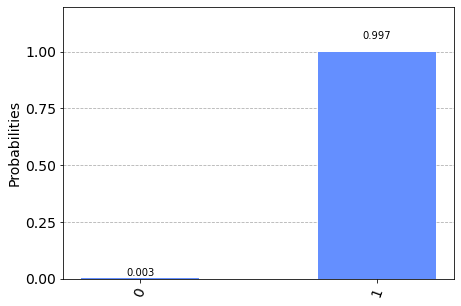

In [244]:
plot_histogram(g1_aer_result.get_counts())

From Hw2, we saw that with z basis measurement, we can get use the following equation to convert probability to expectation value:
$$ \langle Z \rangle = \langle \psi \vert Z \vert \psi \rangle = \langle \psi \lvert (\vert 0 \rangle \langle 0 \vert - \vert 1 \rangle \langle 1 \vert )\rvert \psi \rangle = (\sqrt{0.000})^2 - (\sqrt{0.999})^2 = −0.999 $$ 

In [245]:
g1_energy = g1*(-0.999)
print(g1_energy)

-0.5443551000000001


We want to automate this calculation by exactracting the count values directly from the 'get_counts'output dictionary. We will define the following function:

In [246]:
def get_energy(result,g):
    count1 = 0.0
    count0 = 0.0
    if ('0' in result.get_counts()):
        count0 = result.get_counts()['0']

    if ('1' in result.get_counts()):
        count1 = result.get_counts()['1']

    prob1 = np.sqrt(count1/(count1+count0))
    prob0 = np.sqrt(count0/(count1+count0))
    expectation_val = prob0**2 - prob1**2
    energy = g*(expectation_val)

    return energy

In [247]:
g1_aer_energy = get_energy(g1_aer_result,g1)
print(g1_aer_energy)

-0.5417072265625001


Energy from the g2 term

In [248]:
# g2 <SZ1 I0>
g1 = +0.5449
g2 = -1.2870
g3 = +0.6719
g4 = +0.0798
g5 = +0.0798

# Create initial state |01>
circuit_g2 = QuantumCircuit(2,1)
circuit_g2.name = 'g1_measurement'
circuit_g2.x(1)

# Apply the Ansatz
circuit_g2.ry(np.pi/2,0)
circuit_g2.rx(3*np.pi/2,1)
circuit_g2.cx(0,1)
circuit_g2.rz(3.0546895,1)
circuit_g2.cx(0,1)
circuit_g2.ry(3*np.pi/2,0)
circuit_g2.rx(np.pi/2,1)

# Obtain measurement
circuit_g2.measure([1],[0])
circuit_g2.draw()

┌─────────┐                                    ┌──────────┐   
q_0: ┤ Ry(π/2) ├──────────────■──────────────────■──┤ Ry(3π/2) ├───
     └──┬───┬──┘┌──────────┐┌─┴─┐┌────────────┐┌─┴─┐├─────────┬┘┌─┐
q_1: ───┤ X ├───┤ Rx(3π/2) ├┤ X ├┤ Rz(3.0547) ├┤ X ├┤ Rx(π/2) ├─┤M├
        └───┘   └──────────┘└───┘└────────────┘└───┘└─────────┘ └╥┘
c: 1/════════════════════════════════════════════════════════════╩═
                                                                 0

In [249]:
g2_aer_job = aer_simulator_backend.run(circuit_g2)
g2_aer_result = g2_aer_job.result()
g2_aer_energy = get_energy(g2_aer_result,g2)
print(g2_aer_energy)

-1.287


Energy from the g3 term

In [250]:
# g3 <Sz1 Sz0>
g1 = +0.5449
g2 = -1.2870
g3 = +0.6719
g4 = +0.0798
g5 = +0.0798

# Create initial state |01>
circuit_g3 = QuantumCircuit(2,1)
circuit_g3.name = 'g1_measurement'
circuit_g3.x(1)

# Apply the Ansatz
circuit_g3.ry(np.pi/2,0)
circuit_g3.rx(3*np.pi/2,1)
circuit_g3.cx(0,1)
circuit_g3.rz(3.0546895,1)
circuit_g3.cx(0,1)
circuit_g3.ry(3*np.pi/2,0)
circuit_g3.rx(np.pi/2,1)

# Obtain measurement
circuit_g3.cx(0,1)
circuit_g3.measure([1],[0])
circuit_g3.draw()

┌─────────┐                                    ┌──────────┐        
q_0: ┤ Ry(π/2) ├──────────────■──────────────────■──┤ Ry(3π/2) ├──■─────
     └──┬───┬──┘┌──────────┐┌─┴─┐┌────────────┐┌─┴─┐├─────────┬┘┌─┴─┐┌─┐
q_1: ───┤ X ├───┤ Rx(3π/2) ├┤ X ├┤ Rz(3.0547) ├┤ X ├┤ Rx(π/2) ├─┤ X ├┤M├
        └───┘   └──────────┘└───┘└────────────┘└───┘└─────────┘ └───┘└╥┘
c: 1/═════════════════════════════════════════════════════════════════╩═
                                                                      0

In [251]:
g3_aer_job = aer_simulator_backend.run(circuit_g3)
g3_aer_result = g3_aer_job.result()
g3_aer_energy = get_energy(g3_aer_result,g3)
print(g3_aer_energy)

-0.6719


In [252]:
# g4 <Sx1 Sx0>
g1 = +0.5449
g2 = -1.2870
g3 = +0.6719
g4 = +0.0798
g5 = +0.0798

# Create initial state |01>
circuit_g4 = QuantumCircuit(2,1)
circuit_g4.name = 'g1_measurement'
circuit_g4.x(1)

# Apply the Ansatz
circuit_g4.ry(np.pi/2,0)
circuit_g4.rx(3*np.pi/2,1)
circuit_g4.cx(0,1)
circuit_g4.rz(3.0546895,1)
circuit_g4.cx(0,1)
circuit_g4.ry(3*np.pi/2,0)
circuit_g4.rx(np.pi/2,1)

# Obtain measurement
circuit_g4.cx(0,1)
circuit_g4.h(0)
circuit_g4.h(1)
circuit_g4.measure([1],[0])
circuit_g4.draw()

┌─────────┐                                    ┌──────────┐     ┌───┐   
q_0: ┤ Ry(π/2) ├──────────────■──────────────────■──┤ Ry(3π/2) ├──■──┤ H ├───
     └──┬───┬──┘┌──────────┐┌─┴─┐┌────────────┐┌─┴─┐├─────────┬┘┌─┴─┐├───┤┌─┐
q_1: ───┤ X ├───┤ Rx(3π/2) ├┤ X ├┤ Rz(3.0547) ├┤ X ├┤ Rx(π/2) ├─┤ X ├┤ H ├┤M├
        └───┘   └──────────┘└───┘└────────────┘└───┘└─────────┘ └───┘└───┘└╥┘
c: 1/══════════════════════════════════════════════════════════════════════╩═
                                                                           0

In [253]:
g4_aer_job = aer_simulator_backend.run(circuit_g4)
g4_aer_result = g4_aer_job.result()
g4_aer_energy = get_energy(g4_aer_result,g4)
print(g4_aer_energy)

-0.002026171874999991


In [254]:
# g5 <Sy1 Sy0>
g1 = +0.5449
g2 = -1.2870
g3 = +0.6719
g4 = +0.0798
g5 = +0.0798

# Create initial state |01>
circuit_g5 = QuantumCircuit(2,1)
circuit_g5.name = 'g1_measurement'
circuit_g5.x(1)

# Apply the Ansatz
circuit_g5.ry(np.pi/2,0)
circuit_g5.rx(3*np.pi/2,1)
circuit_g5.cx(0,1)
circuit_g5.rz(3.0546895,1)
circuit_g5.cx(0,1)
circuit_g5.ry(3*np.pi/2,0)
circuit_g5.rx(np.pi/2,1)

# Obtain measurement
circuit_g5.cx(0,1)
circuit_g5.h(0)
circuit_g5.sdg(0)
circuit_g5.h(1)
circuit_g5.sdg(1)

circuit_g5.measure([1],[0])
circuit_g5.draw()

┌─────────┐                                    ┌──────────┐     ┌───┐»
q_0: ┤ Ry(π/2) ├──────────────■──────────────────■──┤ Ry(3π/2) ├──■──┤ H ├»
     └──┬───┬──┘┌──────────┐┌─┴─┐┌────────────┐┌─┴─┐├─────────┬┘┌─┴─┐├───┤»
q_1: ───┤ X ├───┤ Rx(3π/2) ├┤ X ├┤ Rz(3.0547) ├┤ X ├┤ Rx(π/2) ├─┤ X ├┤ H ├»
        └───┘   └──────────┘└───┘└────────────┘└───┘└─────────┘ └───┘└───┘»
c: 1/═════════════════════════════════════════════════════════════════════»
                                                                          »
«     ┌─────┐   
«q_0: ┤ Sdg ├───
«     ├─────┤┌─┐
«q_1: ┤ Sdg ├┤M├
«     └─────┘└╥┘
«c: 1/════════╩═
«             0

In [257]:
g5_aer_job = aer_simulator_backend.run(circuit_g5)
g5_aer_result = g5_aer_job.result()
g5_aer_energy = get_energy(g5_aer_result,g5)
print(g5_aer_energy)

0.003896484375000004


In [258]:
print('g1 Energy: %10.7f Eh' % g1_aer_energy)
print('g2 Energy: %10.7f Eh' % g2_aer_energy)
print('g3 Energy: %10.7f Eh' % g3_aer_energy)
print('g4 Energy: %10.7f Eh' % g4_aer_energy)
print('g5 Energy: %10.7f Eh' % g5_aer_energy)

total_energy = g0 + g1_aer_energy + g2_aer_energy + g3_aer_energy + g4_aer_energy + g5_aer_energy
print('Total Energy: %10.7f Eh' % total_energy)

g1 Energy: -0.5417072 Eh
g2 Energy: -1.2870000 Eh
g3 Energy: -0.6719000 Eh
g4 Energy: -0.0020262 Eh
g5 Energy:  0.0038965 Eh
Total Energy: -0.3119369 Eh


**2. First, try using Ionq simulator**

In [205]:
g1_ionq_job = ionq_simulator_backend.run(circuit_g1)
g1_ionq_result = g1_ionq_job.result()

............

In [206]:
g2_ionq_job = ionq_simulator_backend.run(circuit_g2)
g2_ionq_result = g2_ionq_job.result()

............

In [207]:
g3_ionq_job = ionq_simulator_backend.run(circuit_g3)
g3_ionq_result = g3_ionq_job.result()

............

In [208]:
g4_ionq_job = ionq_simulator_backend.run(circuit_g4)
g4_ionq_result = g4_ionq_job.result()

...........

In [209]:
g5_ionq_job = ionq_simulator_backend.run(circuit_g5)
g5_ionq_result = g5_ionq_job.result()

...........

In [259]:
g1_ionq_energy = get_energy(g1_ionq_result,g1)
g2_ionq_energy = get_energy(g2_ionq_result,g2)
g3_ionq_energy = get_energy(g3_ionq_result,g3)
g4_ionq_energy = get_energy(g4_ionq_result,g4)
g5_ionq_energy = get_energy(g5_ionq_result,g5)

In [284]:
print('g1 Energy: %10.7f Eh' % g1_ionq_energy)
print('g2 Energy: %10.7f Eh' % g2_ionq_energy)
print('g3 Energy: %10.7f Eh' % g3_ionq_energy)
print('g4 Energy: %10.7f Eh' % g4_ionq_energy)
print('g5 Energy: %10.7f Eh' % g5_ionq_energy)

total_energy = g0 + g1_ionq_energy + g2_ionq_energy + g3_ionq_energy + g4_ionq_energy + g5_ionq_energy
print('Total Energy: %10.7f Eh' % total_energy)

g1 Energy: -0.5405408 Eh
g2 Energy: -1.2870000 Eh
g3 Energy: -0.6719000 Eh
g4 Energy: -0.0031920 Eh
g5 Energy: -0.0028728 Eh
Total Energy: -0.3187056 Eh


**3. Prepare to submit job to ionQ. We first run cost estimates**

In [265]:
circ = qiskit.transpile(circuit_g5, ionq_qpu_backend)
cost = ionq_qpu_backend.estimate_cost(circ, shots=200)
print(cost)

{'additional_properties': {}, 'currency_code': 'USD', 'events': [<azure.quantum._client.models._models_py3.UsageEvent object at 0x7fa968f90090>, <azure.quantum._client.models._models_py3.UsageEvent object at 0x7fa969051f90>], 'estimated_total': 1.0}


In [266]:
circ = qiskit.transpile(circuit_g5, ionq_qpu_backend)
cost = ionq_qpu_backend.estimate_cost(circ, shots=200)
print(cost)

{'additional_properties': {}, 'currency_code': 'USD', 'events': [<azure.quantum._client.models._models_py3.UsageEvent object at 0x7fa969034510>, <azure.quantum._client.models._models_py3.UsageEvent object at 0x7fa969034ed0>], 'estimated_total': 1.0}


In [267]:
circ = qiskit.transpile(circuit_g5, ionq_qpu_backend)
cost = ionq_qpu_backend.estimate_cost(circ, shots=1000)
print(cost)

{'additional_properties': {}, 'currency_code': 'USD', 'events': [<azure.quantum._client.models._models_py3.UsageEvent object at 0x7fa96900f750>, <azure.quantum._client.models._models_py3.UsageEvent object at 0x7fa96900fb90>], 'estimated_total': 1.17}


In [268]:
circ = qiskit.transpile(circuit_g5, ionq_qpu_backend)
cost = ionq_qpu_backend.estimate_cost(circ, shots=5000)
print(cost)

{'additional_properties': {}, 'currency_code': 'USD', 'events': [<azure.quantum._client.models._models_py3.UsageEvent object at 0x7fa968f8ced0>, <azure.quantum._client.models._models_py3.UsageEvent object at 0x7fa969051990>], 'estimated_total': 5.8500000000000005}


In [301]:
circ = qiskit.transpile(circuit_g5, ionq_qpu_backend)
cost = ionq_qpu_backend.estimate_cost(circ, shots=10000)
print(cost)

{'additional_properties': {}, 'currency_code': 'USD', 'events': [<azure.quantum._client.models._models_py3.UsageEvent object at 0x7fa969051150>, <azure.quantum._client.models._models_py3.UsageEvent object at 0x7fa969051b50>], 'estimated_total': 11.700000000000001}


**4. Running IonQ jobs on QPU **

In [269]:
g1_qpu_200 = ionq_qpu_backend.run(circuit_g1,shots=200)

In [273]:
g2_qpu_200 = ionq_qpu_backend.run(circuit_g2,shots=200)

In [278]:
g3_qpu_200 = ionq_qpu_backend.run(circuit_g3,shots=200)
g4_qpu_200 = ionq_qpu_backend.run(circuit_g4,shots=200)
g5_qpu_200 = ionq_qpu_backend.run(circuit_g5,shots=200)

In [279]:
g1_qpu_500 = ionq_qpu_backend.run(circuit_g1,shots=500)
g2_qpu_500 = ionq_qpu_backend.run(circuit_g2,shots=500)
g3_qpu_500 = ionq_qpu_backend.run(circuit_g3,shots=500)
g4_qpu_500 = ionq_qpu_backend.run(circuit_g4,shots=500)
g5_qpu_500 = ionq_qpu_backend.run(circuit_g5,shots=500)

In [280]:
g1_qpu_1000 = ionq_qpu_backend.run(circuit_g1,shots=1000)
g2_qpu_1000 = ionq_qpu_backend.run(circuit_g2,shots=1000)
g3_qpu_1000 = ionq_qpu_backend.run(circuit_g3,shots=1000)
g4_qpu_1000 = ionq_qpu_backend.run(circuit_g4,shots=1000)
g5_qpu_1000 = ionq_qpu_backend.run(circuit_g5,shots=1000)

In [281]:
g1_qpu_5000 = ionq_qpu_backend.run(circuit_g1,shots=5000)
g2_qpu_5000 = ionq_qpu_backend.run(circuit_g2,shots=5000)
g3_qpu_5000 = ionq_qpu_backend.run(circuit_g3,shots=5000)
g4_qpu_5000 = ionq_qpu_backend.run(circuit_g4,shots=5000)
g5_qpu_5000 = ionq_qpu_backend.run(circuit_g5,shots=5000)

**5. Analyzing Qpu result**

***5.1 200 Shots***

In [282]:
g1_qpu_200_result = g1_qpu_200.result()
g2_qpu_200_result = g2_qpu_200.result()
g3_qpu_200_result = g3_qpu_200.result()
g4_qpu_200_result = g4_qpu_200.result()
g5_qpu_200_result = g5_qpu_200.result()

In [286]:
g1_qpu_200_energy = get_energy(g1_qpu_200_result,g1)
g2_qpu_200_energy = get_energy(g2_qpu_200_result,g2)
g3_qpu_200_energy = get_energy(g3_qpu_200_result,g3)
g4_qpu_200_energy = get_energy(g4_qpu_200_result,g4)
g5_qpu_200_energy = get_energy(g5_qpu_200_result,g5)

In [287]:
print('g1 Energy: %10.7f Eh' % g1_qpu_200_energy)
print('g2 Energy: %10.7f Eh' % g2_qpu_200_energy)
print('g3 Energy: %10.7f Eh' % g3_qpu_200_energy)
print('g4 Energy: %10.7f Eh' % g4_qpu_200_energy)
print('g5 Energy: %10.7f Eh' % g5_qpu_200_energy)

total_energy = g0 + g1_qpu_200_energy + g2_qpu_200_energy + g3_qpu_200_energy + g4_qpu_200_energy + g5_qpu_200_energy
print('Total Energy: %10.7f Eh' % total_energy)

g1 Energy: -0.4522670 Eh
g2 Energy: -1.1196900 Eh
g3 Energy: -0.4434540 Eh
g4 Energy:  0.0000000 Eh
g5 Energy:  0.0000000 Eh
Total Energy:  0.1713890 Eh


***5.2 500 Shots***

In [291]:
g1_qpu_500_result = g1_qpu_500.result()
g2_qpu_500_result = g2_qpu_500.result()
g3_qpu_500_result = g3_qpu_500.result()
g4_qpu_500_result = g4_qpu_500.result()
g5_qpu_500_result = g5_qpu_500.result()

In [292]:
g1_qpu_500_energy = get_energy(g1_qpu_500_result,g1)
g2_qpu_500_energy = get_energy(g2_qpu_500_result,g2)
g3_qpu_500_energy = get_energy(g3_qpu_500_result,g3)
g4_qpu_500_energy = get_energy(g4_qpu_500_result,g4)
g5_qpu_500_energy = get_energy(g5_qpu_500_result,g5)

In [293]:
print('g1 Energy: %10.7f Eh' % g1_qpu_500_energy)
print('g2 Energy: %10.7f Eh' % g2_qpu_500_energy)
print('g3 Energy: %10.7f Eh' % g3_qpu_500_energy)
print('g4 Energy: %10.7f Eh' % g4_qpu_500_energy)
print('g5 Energy: %10.7f Eh' % g5_qpu_500_energy)

total_energy = g0 + g1_qpu_500_energy + g2_qpu_500_energy + g3_qpu_500_energy + g4_qpu_500_energy + g5_qpu_500_energy
print('Total Energy: %10.7f Eh' % total_energy)

g1 Energy: -0.3487360 Eh
g2 Energy: -1.1583000 Eh
g3 Energy: -0.4542044 Eh
g4 Energy: -0.0019152 Eh
g5 Energy: -0.0041496 Eh
Total Energy:  0.2194948 Eh


***5.3 1000 Shots***

In [294]:
g1_qpu_1000_result = g1_qpu_1000.result()
g2_qpu_1000_result = g2_qpu_1000.result()
g3_qpu_1000_result = g3_qpu_1000.result()
g4_qpu_1000_result = g4_qpu_1000.result()
g5_qpu_1000_result = g5_qpu_1000.result()

In [295]:
g1_qpu_1000_energy = get_energy(g1_qpu_1000_result,g1)
g2_qpu_1000_energy = get_energy(g2_qpu_1000_result,g2)
g3_qpu_1000_energy = get_energy(g3_qpu_1000_result,g3)
g4_qpu_1000_energy = get_energy(g4_qpu_1000_result,g4)
g5_qpu_1000_energy = get_energy(g5_qpu_1000_result,g5)

In [297]:
print('g1 Energy: %10.7f Eh' % g1_qpu_1000_energy)
print('g2 Energy: %10.7f Eh' % g2_qpu_1000_energy)
print('g3 Energy: %10.7f Eh' % g3_qpu_1000_energy)
print('g4 Energy: %10.7f Eh' % g4_qpu_1000_energy)
print('g5 Energy: %10.7f Eh' % g5_qpu_1000_energy)

total_energy = g0 + g1_qpu_1000_energy + g2_qpu_1000_energy + g3_qpu_1000_energy + g4_qpu_1000_energy + g5_qpu_1000_energy
print('Total Energy: %10.7f Eh' % total_energy)

g1 Energy: -0.3912382 Eh
g2 Energy: -1.1866140 Eh
g3 Energy: -0.5590208 Eh
g4 Energy: -0.0039900 Eh
g5 Energy: -0.0046284 Eh
Total Energy:  0.0413086 Eh


***5.4 5000 Shots***

In [298]:
g1_qpu_5000_result = g1_qpu_5000.result()
g2_qpu_5000_result = g2_qpu_5000.result()
g3_qpu_5000_result = g3_qpu_5000.result()
g4_qpu_5000_result = g4_qpu_5000.result()
g5_qpu_5000_result = g5_qpu_5000.result()

In [299]:
g1_qpu_5000_energy = get_energy(g1_qpu_5000_result,g1)
g2_qpu_5000_energy = get_energy(g2_qpu_5000_result,g2)
g3_qpu_5000_energy = get_energy(g3_qpu_5000_result,g3)
g4_qpu_5000_energy = get_energy(g4_qpu_5000_result,g4)
g5_qpu_5000_energy = get_energy(g5_qpu_5000_result,g5)

In [300]:
print('g1 Energy: %10.7f Eh' % g1_qpu_5000_energy)
print('g2 Energy: %10.7f Eh' % g2_qpu_5000_energy)
print('g3 Energy: %10.7f Eh' % g3_qpu_5000_energy)
print('g4 Energy: %10.7f Eh' % g4_qpu_5000_energy)
print('g5 Energy: %10.7f Eh' % g5_qpu_5000_energy)

total_energy = g0 + g1_qpu_5000_energy + g2_qpu_5000_energy + g3_qpu_5000_energy + g4_qpu_5000_energy + g5_qpu_5000_energy
print('Total Energy: %10.7f Eh' % total_energy)

g1 Energy: -0.4993464 Eh
g2 Energy: -1.2324312 Eh
g3 Energy: -0.6407238 Eh
g4 Energy:  0.0054264 Eh
g5 Energy:  0.0028728 Eh
Total Energy: -0.1774022 Eh


As we can see, using the simulators, we can roughly recover the energy of the H2 molecule. However, using QPU, we need 5000 shots to just get the sign correct, with ~50% error too, which is not good at all.